In [62]:
from os import listdir
from os.path import join, isfile
from deap import base, creator, tools, algorithms

import random
import numpy as np
import matplotlib.pyplot as plt

plt_styles = plt.style.available
plt.style.use(plt_styles[7])


In [63]:
def get_data_from_file(path: str):
    with open(path, "r") as f:
        data = []
        lines = f.readlines()
        for line in lines:
            data.append([int(c) for c in line.split()])
        return data


def get_paths_of_dir(path: str, extension: str):
    return [join(path, f) for f in listdir(path)
            if isfile(join(path, f)) and f.endswith(extension)]
    

In [64]:
inDirPath = "../../Input/"
inPaths = get_paths_of_dir(inDirPath, extension=".in")

In [65]:
n_problem = int(input(f"Elige el problema (1-{len(inPaths)}): "))

inDirFiles = listdir(inDirPath)
file_name = inDirFiles[n_problem - 1]

path = inPaths[n_problem - 1]
prob = get_data_from_file(path)

## Variable meanings.

* R = Number of rows.
* C = Number of columns.
* F = Number of cars.
* N = Pre-booked rides.
* B = Per-ride bonus for starting the ride on time.
* T = Simulation steps = distance between start and end.

In [66]:
# Problem data.
_, _, F, N, B, T = prob[0]

# Rides.
rides = prob[1:-1]

# Car accessibility.
adapted = prob[-1]

Bonus:
* Earn points proportional to distance of ride.
* Bonus if started on time. 

In [67]:
toolbox = base.Toolbox()

In [68]:
if not hasattr(creator, "Fitness"):
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))

if not hasattr(creator, "Individual"):
    creator.create("Individual", list, fitness=creator.FitnessMax)


C:\Users\Ivan\AppData\Local\Programs\Python\Python38\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [69]:
toolbox.register("attribute", random.randint, 0, F - 1)
toolbox.register("individual", tools.initRepeat,
                 creator.Individual, toolbox.attribute, n=N)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [70]:
def sort_rides(car_rides):
    def sort_ride(ride):
        a, b, x, y, s, f, _ = ride
        origin = [a, b]
        destiny = [x, y]
        distance = dis(origin, destiny)

        return s + f - distance

    return sorted(car_rides, key=lambda ride: sort_ride(ride[1]))


def get_rides_from_ind(individual):
    cars_rides = np.full(F, None)

    for i, car in enumerate(individual):
        v_r = cars_rides[car]

        if v_r is None:
            v_r = []

        ride = rides[i]
        v_r.append([i, ride])

        cars_rides[car] = v_r

    return cars_rides


def dis(a, b): return np.abs(a[0] - b[0]) + np.abs(a[1]-b[1])


In [71]:


def calc_fitness(car_rides):
    fitness = 0
    step = 0
    pos = [0, 0]

    # Sort car_rides given earliest time.
    car_rides = sort_rides(car_rides)

    for _, ride in car_rides:
        a, b, x, y, earliest_start, latest_finish, _ = ride
        origin = [a, b]
        destiny = [x, y]

        # 1.- Go to origin.
        step += dis(pos, origin)

        # 2.- If arrived before the earliest time. Wait and earn bonus.
        if step <= earliest_start:
            fitness += B
            step = earliest_start

        # 3.- Go to destiny.
        dis_ori_des = dis(origin, destiny)
        step += dis_ori_des

        # 4.- If reached destiny before latest finish. Earn points.
        if step <= latest_finish:
            fitness += dis_ori_des

        # 5.- Update position.
        pos = destiny

        # 6.- Check if reached max distance with one car.
        if step > T:
            break

    return fitness


def eval_ind(ind):
    all_rides = get_rides_from_ind(ind)

    fitness = 0

    for _, car_rides in enumerate(all_rides):
        if car_rides is not None:
            _fitness = calc_fitness(car_rides)
            fitness += _fitness

    return fitness,


In [72]:
TOURNSIZE = 3
INDPB = 0.2

toolbox.register("select", tools.selTournament, tournsize=TOURNSIZE)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutUniformInt, indpb=INDPB, low=0, up=F-1)
toolbox.register("evaluate", eval_ind)


In [73]:
def get_penalty(ind):
    pen = 0

    for i_ride, i_car in enumerate(ind):
        adapted_ride = rides[i_ride][-1]
        adapted_car = adapted[i_car]

        if adapted_car == 0 and adapted_ride == 1:
            pen += 1

    return pen


def distance(ind):
    pen = get_penalty(ind)
    return pen


def feasible(ind):
    pen = get_penalty(ind)
    return pen == 0


![Constraints](https://deap.readthedocs.io/en/master/_images/constraints.png)

In [74]:
DISTANCE_OFFSET = 0

toolbox.decorate("evaluate", tools.DeltaPenality(
    feasible, DISTANCE_OFFSET, distance))


In [75]:
NIND = 300

pop = toolbox.population(n=NIND)


In [76]:
ind = toolbox.individual()

print("Individuo")
print(ind[1:20])

print("Individuo ANTES de evaluar")
print(f"Valid: {ind.fitness.valid}")

ind.fitness.values = eval_ind(ind)

print("Individuo TRAS evaluar")
print(f"Valid: {ind.fitness.valid}. Fitness = {ind.fitness.values}")


Individuo
[80, 38, 34, 52, 70, 9, 51, 70, 84, 9, 89, 63, 97, 91, 83, 14, 20, 12, 28]
Individuo ANTES de evaluar
Valid: False
Individuo TRAS evaluar
Valid: True. Fitness = (164040.0,)


In [77]:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("max", np.max)
stats.register("std", np.std)
stats.register("avg", np.average)


In [78]:
NGEN = 50
CXPB = 0.8
MUTPB = 0.1

pop, logbook = algorithms.eaSimple(
    pop, toolbox, CXPB, MUTPB, NGEN, stats, verbose=False)

In [79]:
best_sol = tools.selBest(pop, k=1)[0]

print(f"El resultado de la evolución es:")
print(logbook)
print(
    f"Mejor solución es {best_sol[1:10]} con fitness {eval_ind(best_sol)}")


El resultado de la evolución es:
gen	nevals	min	max	std    	avg     
0  	300   	-78	-56	4.11694	-66.7467
1  	239   	-72	-53	3.68476	-63.2567
2  	250   	-69	-47	3.64218	-60.1767
3  	239   	-69	-46	3.44837	-57.39  
4  	249   	-65	-46	3.44134	-54.9767
5  	251   	-63	-43	3.62629	-52.1733
6  	240   	-61	-42	3.23346	-49.59  
7  	254   	-59	-41	2.92189	-47.2433
8  	246   	-54	-38	2.76867	-45.1667
9  	250   	-57	-36	2.77786	-43.4867
10 	230   	-53	-34	2.74848	-41.75  
11 	250   	-51	-33	2.65066	-40.0633
12 	244   	-50	-32	2.76538	-38.2633
13 	243   	-50	-30	2.74016	-36.6867
14 	249   	-53	-30	3.02692	-35.4667
15 	251   	-46	-29	2.65565	-34.0867
16 	245   	-45	-27	2.79093	-32.8067
17 	252   	-44	-26	3.13392	-31.8767
18 	250   	-42	-25	2.52433	-30.4333
19 	254   	-41	-24	2.84217	-29.4267
20 	267   	-42	-24	3.00275	-28.4867
21 	262   	-41	-24	2.7822 	-27.4033
22 	244   	-45	-22	2.71281	-26.4367
23 	241   	-37	-22	2.79224	-25.4933
24 	233   	-38	-21	2.33669	-24.2767
25 	236   	-38	-21	3.11818	-23.

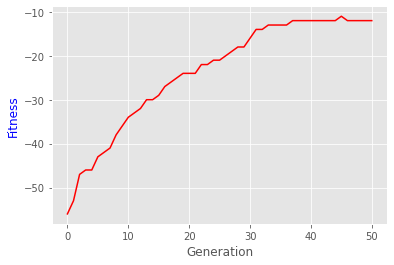

In [80]:
def plot_pen_fitness(lb):
  gen = lb.select("gen")
  maxs = lb.select("max")

  fig, ax = plt.subplots()

  line = ax.plot(gen, maxs, "r-", label="Average Fitness")
  ax.set_xlabel("Generation")
  ax.set_ylabel("Fitness", color="b")

  plt.plot()
  
plot_pen_fitness(logbook)

In [81]:
outDirPath = "../../Output/"
outFilePath = outDirPath + file_name.strip(".in") + ".out"

cars_rides = get_rides_from_ind(best_sol)

with open(outFilePath, "w") as f:
    for v_r in cars_rides:
      if v_r is None:
        f.write(str(0))
      else:
        v_r = sort_rides(v_r)    
        f.write(str(len(v_r)))
        f.write(" ")
        f.write(" ".join(str(pos) for pos, _ in v_r))
      
      f.write("\n")